In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, matthews_corrcoef)

In [2]:
# Create folder in which all figures and files are being saved
os.makedirs('Feature_Importance', exist_ok=True)

In [3]:
df = pd.read_csv("all_traces_norm.tsv_train_val.tsv", sep="\t")

In [4]:
def xgb_analysis(
    df: pd.DataFrame,
    dateiname_conf="confusion_matrix.png",
    dateiname_feat="feature_importance.png",
    test_size=0.2,
    random_state=42
):
    """
    Train and evaluate an XGBoost classifier, then save and show
    the confusion matrix and feature importance plots.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the dataset (columns 0-2: metadata, 3+: features).
    dateiname_conf : str, optional
        Filename to save the confusion matrix plot.
    dateiname_feat : str, optional
        Filename to save the feature importance plot.
    test_size : float, optional
        Proportion of data used for testing (default 0.2).
    random_state : int, optional
        Random seed for reproducibility (default 42).

    Returns
    -------
    dict
        Contains model, label_map, metrics, and predictions.
    """

    # -----------------------------
    # Separate features and labels
    # -----------------------------
    X = df.iloc[:, 3:].values
    y_raw = df.iloc[:, 0]

    # Dynamic label mapping
    label_map = {label: idx for idx, label in enumerate(y_raw.unique())}
    y = y_raw.map(label_map).values

    print("Label mapping:", label_map)
    print("Mapped class labels:", np.unique(y, return_counts=True))

    # -----------------------------
    # Train/test split
    # -----------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # -----------------------------
    # Train XGBoost classifier
    # -----------------------------
    model = XGBClassifier(eval_metric='logloss', random_state=random_state)
    model.fit(X_train, y_train)

    # -----------------------------
    # Predictions & Metrics
    # -----------------------------
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # -----------------------------
    # Confusion Matrix
    # -----------------------------
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(
    cm, annot=True, fmt=".2f", cmap="Blues",
    xticklabels=label_map.keys(), yticklabels=label_map.keys(),
    cbar_kws={'label': 'Proportion'}
    )
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.tight_layout()
    plt.savefig(dateiname_conf, dpi=300, bbox_inches='tight')
    plt.show()

    # -----------------------------
    # Feature Importance
    # -----------------------------
    importance_scores = model.feature_importances_
    feature_names = df.columns[3:]
    colors = plt.cm.viridis(importance_scores / max(importance_scores))

    plt.figure(figsize=(12, 6))
    plt.bar(feature_names, importance_scores, color=colors)
    plt.xticks(rotation=90)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Importance Score", fontsize=12)
    plt.title("XGBoost Feature Importances", fontsize=14)
    plt.margins(x=0)  # remove white space at plot edges
    plt.tight_layout(pad=0)
    plt.savefig(dateiname_feat, dpi=300, bbox_inches='tight')
    plt.show()

    # -----------------------------
    # Return useful outputs
    # -----------------------------
    return {
        "model": model,
        "label_map": label_map,
        "accuracy": acc,
        "mcc": mcc,
        "y_true": y_test,
        "y_pred": y_pred
    }

Label mapping: {'PR8': 0, 'X31': 1}
Mapped class labels: (array([0, 1], dtype=int64), array([1413,  751], dtype=int64))

Accuracy: 0.6721
MCC: 0.2190

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       283
           1       0.54      0.35      0.42       150

    accuracy                           0.67       433
   macro avg       0.63      0.60      0.60       433
weighted avg       0.65      0.67      0.65       433



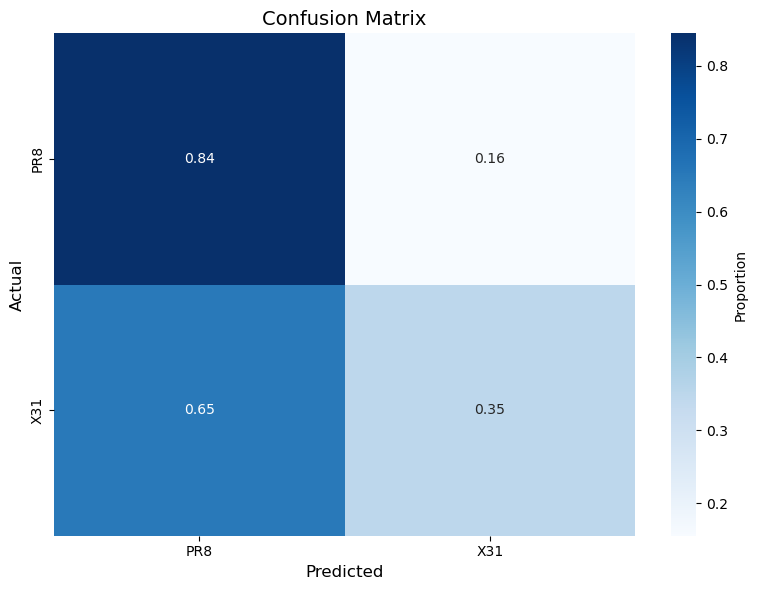

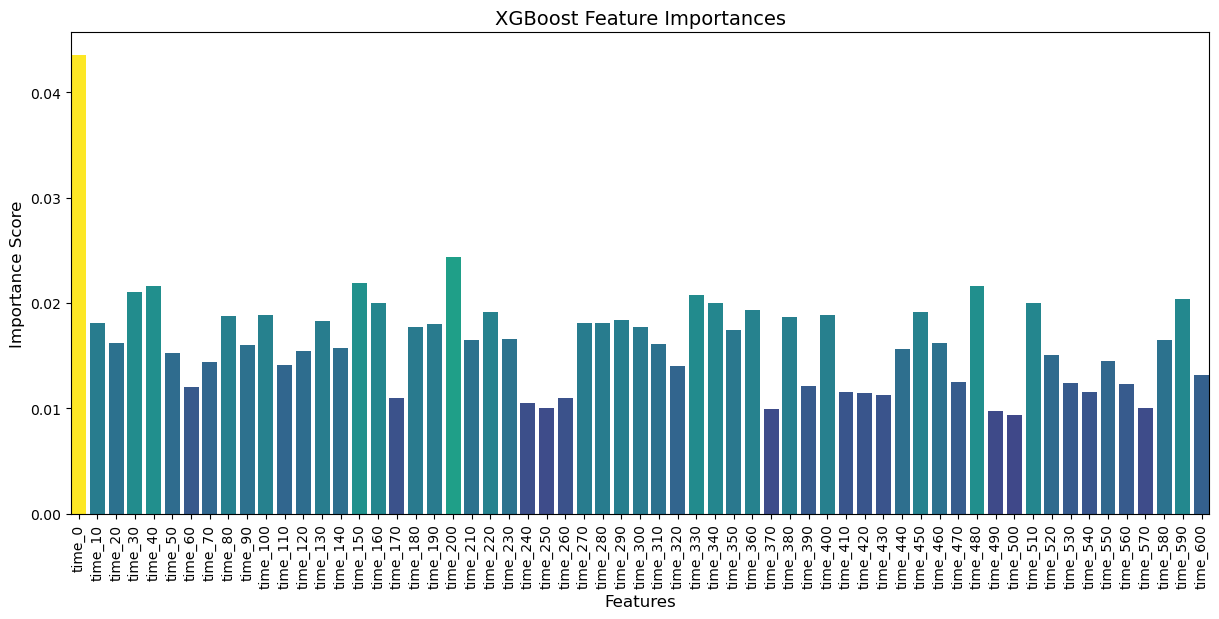

In [5]:
results = xgb_analysis(df,
                       dateiname_conf="Feature_Importance/confusion_matrix_norm.png",
                       dateiname_feat="Feature_Importance/feat_importance_norm.png")

In [6]:
df1 = pd.read_csv("all_traces_norm_imputation.tsv_train_val.tsv", sep="\t")

Label mapping: {'PR8': 0, 'X31': 1}
Mapped class labels: (array([0, 1], dtype=int64), array([1413,  751], dtype=int64))

Accuracy: 0.6120
MCC: 0.0341

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.83      0.74       283
           1       0.38      0.19      0.26       150

    accuracy                           0.61       433
   macro avg       0.52      0.51      0.50       433
weighted avg       0.56      0.61      0.57       433



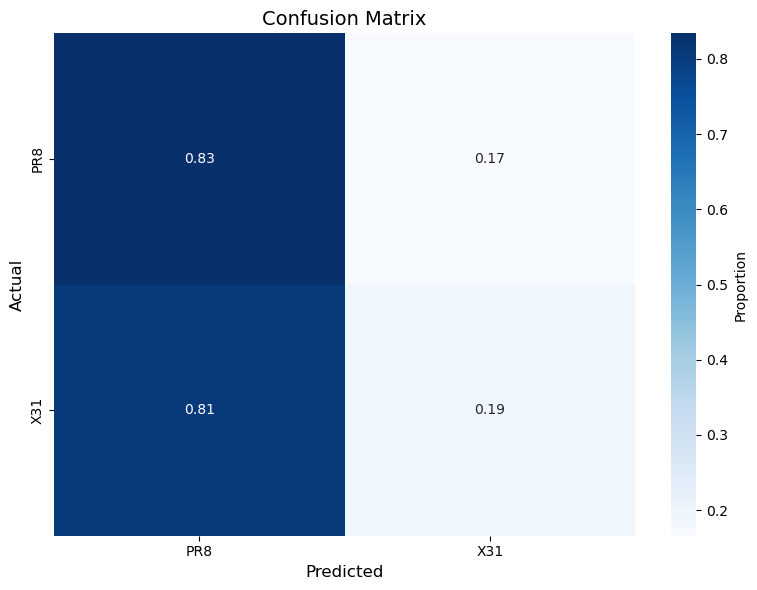

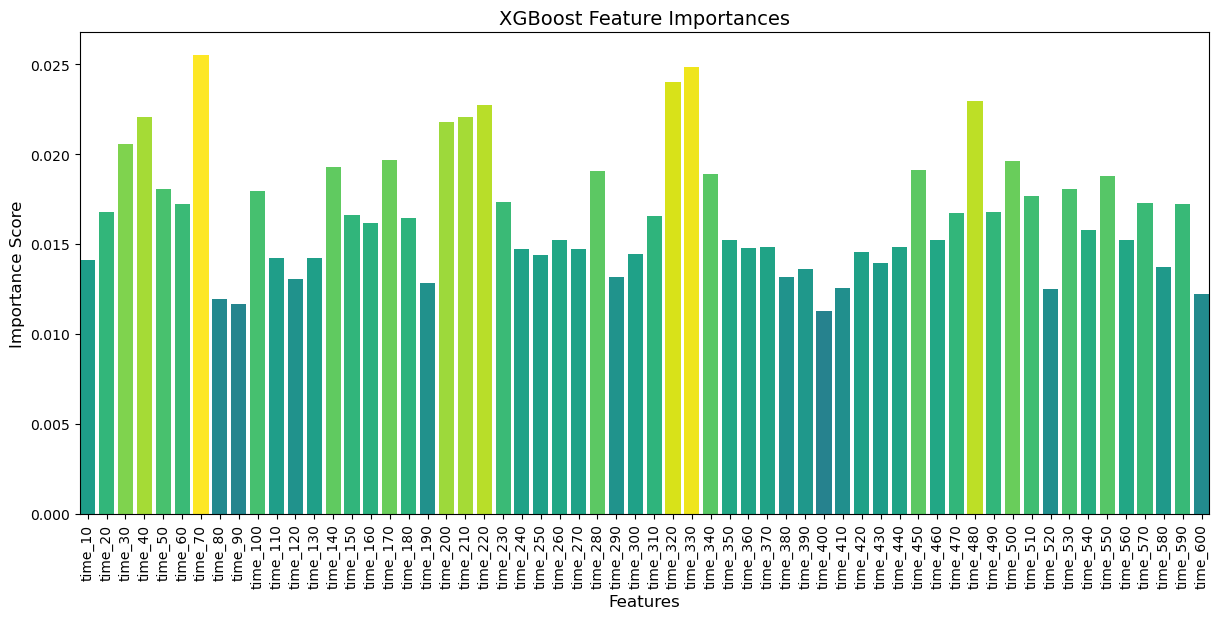

In [7]:
results = xgb_analysis(df1,
                       dateiname_conf="Feature_Importance/confusion_matrix_norm_imp.png",
                       dateiname_feat="Feature_Importance/feat_importance_norm_imp.png")